In [1]:
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon
from pyproj import Proj, transform
import folium
import numpy as np

In [2]:
vitesse = 2 # en m/s, représente la vitesse de l'eau dans les tuyaux
delta_T = 26 # en Kelvin, représente l'écart de température intérieur/extérieur qui est pris dans les normes énergétiques
T = 60 # en Kelvin, repésente la température de l'eau dans les tuyaux
rho = 1000 # en kg/m3, représente la masse volumique de l'eau
c_p = 4.18 # en kJ/K/kg, représente la capacité massique de l'eau

# Ici, on a pris arbitrairement la ville d'Aubervilliers, mais tout le paragraphe du dessous est modifiable. On définit la source par ses coordonnées,
# et on définit les bâtiments soit par leurs coordonnées, soit par leur adresse. On peut aussi définir arbitrairement des bâtiments avec des débit fixés en amont
# du calcul réalisé fait par le programme

ville = "Aubervilliers"
coords_source = [48.912, 2.386]
liste_adresses = ['12 rue du colonel fabien', '117 rue de saint denis',
       '105 avenue jean jaures', '31 rue ferragus', '43 rue heurtault',
       '3 rue pierre curie', '14 rue emile augier',
       '19 B chemin du haut saint denis', '21 passage machouart',
       '27 passage machouart', '28 rue claude bernard', '32 B rue bisson',
       '17 rue alphonse daudet', '29 rue alphonse daudet',
       '37 rue alphonse daudet', '20 rue alphonse daudet',
       '6 passage de la justice', '10 rue gaetan lamy',
       '3 rue cesaria evora', '23 rue gaetan lamy', '72 rue du landy',
       '14 rue gaetan lamy']#, '3 rue du colonel fabien']
dic_coords_puis = {(48.913247,2.395552): 30, (48.914171, 2.394372): 50}


In [3]:
# Avec le module OSNMX, on importe le graphe de la ville en question, et on enlève "la directionnalité" des chemins (dans le projet, on n'a pas besoin de savoir le sens de la route)

G = ox.graph_from_place(ville + ", France", simplify=False)
M = ox.convert.to_undirected(G)

In [4]:
# On récupère de manière distincte les noeuds et les arrêtes du graphe pour plus tard

gdf_nodes, gdf_edges = ox.graph_to_gdfs(M)

In [5]:
# On instaure 3 matrices de coefficient de transmission thermique, qui retourne le coefficient de transmission thermique adapté en fonction
# de l'année de construction et du moyen de chauffage du bâtiment

mat_u_mur = [[2.5,2.5],[2.5,2.5],[1.25,1.33],[0.45,0.5],[0.4,0.4],[0.36,0.36],[0.23,0.23]]
mat_u_bas = [[2,2],[2,2],[1.05,1.16],[0.55,0.5],[0.3,0.3],[0.27,0.27],[0.23,0.23]]
mat_u_haut = [[2.5,2.5],[2.5,2.5],[0.94,0.94],[0.25,0.25],[0.23,0.23],[0.2,0.2],[0.14,0.14]]
dico_annee = {"<1948":0,"1949-1970":1,"1970-1988":2,"1989-1999":3,"2000-2005":4,"2006-2012":5,">2012":6}

In [6]:
# On récupère dans les données de la BDNB de la Seine-Saint-Denis (où se situe Aubervilliers) et on  en garde 4 tableaux de données CSV

df_adr = pd.read_csv('adresse.csv')
df_bat_adr = pd.read_csv('batiment_groupe_adresse.csv')
df_dpe = pd.read_csv('batiment_groupe_dpe_logtype.csv')
df_constr = pd.read_csv('batiment_construction.csv')

In [7]:
# On merge ces 4 DataFrame en 1 seul

df = pd.merge(df_dpe, df_bat_adr, on = 'batiment_groupe_id')
df = pd.merge(df, df_adr, left_on = 'cle_interop_adr_principale_ban', right_on = 'cle_interop_adr')
df = pd.merge(df, df_constr, on = 'batiment_groupe_id', suffixes=('', 'constr'))

In [8]:
# On sélectionne uniquement les bâtiments de notre réseau, et on ne garde que les colonnes qui nous intéressent pour la suite

df = df[df['libelle_commune'] == ville]
df['adresse'] = df['libelle_adr_principale_ban'].str.split(',').str[0]
df = df[df['adresse'].isin(liste_adresses)]
df = df[['WKT', 'periode_construction', 'mur_u_ext', 'pb_u', 'ph_u','WKTconstr', 'hauteur', 'ch_type_ener_corr', 'adresse']]

In [9]:
# A partir de la colonne 'WKTconstr', on détermine la surface ainsi que le périmètre du bâtiment qui seront utiles pour le calcul du débit nécessaire

df['surface'] = None
df['perimetre'] = None
for i in df.index:
    a = df['WKTconstr'].loc[i]
    geom = wkt.loads(a)
    df.loc[i, 'surface'] = geom.area
    df.loc[i, 'perimetre'] = geom.length

In [10]:
# On attribue à chacun des bâtiments dont les coefficients de transmission thermique sont inconnus une valeur déterminée par
# l'année de construction et le type de chauffage du bâtiment

df = df.fillna("Non identifie")
for i in df.index:
    type_chauff = df.loc[i,"ch_type_ener_corr"]
    plage_periode = dico_annee[df.loc[i,"periode_construction"]]
    if df.loc[i,"mur_u_ext"] == "Non identifie":
        if type_chauff == "electricite":
            df.loc[i,"mur_u_ext"] = mat_u_mur[plage_periode][0]
        else:
            df.loc[i,"mur_u_ext"] = mat_u_mur[plage_periode][1]
    if df.loc[i,"pb_u"] == "Non identifie":
        if type_chauff == "electricite":
            df.loc[i,"pb_u"] = mat_u_bas[plage_periode][0]
        else:
            df.loc[i,"pb_u"] = mat_u_bas[plage_periode][1]
    if df.loc[i,"ph_u"] == "Non identifie":
        if type_chauff == "electricite":
            df.loc[i,"ph_u"] = mat_u_haut[plage_periode][0]
        else:
            df.loc[i,"ph_u"] = mat_u_haut[plage_periode][1]

C:\Users\Valentin\AppData\Local\Temp\ipykernel_8480\2179719453.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("Non identifie")


In [11]:
# A partir de toutes les données, on calcule le débit nécessaire à l'aide de cette fonction

def calcul_debit(surface, perimetre, hauteur, u_mur, u_haut, u_bas):
  puissance = delta_T*(perimetre*hauteur*u_mur+surface*(u_haut+u_bas))
  debit = puissance/(c_p*T*rho)
  return(debit)

In [12]:
# On crée la nouvelle colonne "débit" avec le débit correspondant pour chacun des bâtiments

for i in df.index:
    s = df.loc[i,"surface"]
    p = df.loc[i,"perimetre"]
    h = df.loc[i,"hauteur"]
    u_mur = df.loc[i,"mur_u_ext"]
    u_haut = df.loc[i,"ph_u"]
    u_bas = df.loc[i,"pb_u"]
    df.loc[i,"debit"] = calcul_debit(s,p,h,u_mur,u_haut,u_bas)

In [13]:
# Vu qu'une adresse peut regrouper plusieurs bâtiments, on regroupe les bâtiments avec la même adresse, en sommant les débits

df = df[["WKT","adresse","debit"]]
df = df.groupby(["WKT","adresse"], as_index= False).sum()

In [14]:
# On créé les colonnes "latitude" et "longitude"

src_crs = Proj(init='epsg:2154')
dst_crs = Proj(init='epsg:4326')
df['lon'] = None
df['lat'] = None

c:\miniconda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\miniconda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [15]:
# Les coordonnées de la BDNB étant en Lambert 93 et pas dans les coordonnées géographiques classiques, il faut les convertir

def conversion (bat):
    a = df['WKT'].loc[bat]
    geom = wkt.loads(a)
    lon, lat = transform(src_crs, dst_crs, geom.x, geom.y)
    return (lat, lon, ox.distance.nearest_nodes(G,lon,lat))

In [16]:
# On rajoute une colonne "node" qui répertorie le noeud du graphe le "plus proche" de chacune des adresses,
# et on remplit les colonnes "latitude" et "longitude"

df['nodes'] = None
for i in df.index:
   lat, lon, node = conversion(i)
   df.loc[i, 'lat'] = lat
   df.loc[i, 'lon'] = lon
   df.loc[i, 'nodes'] = node
df.drop(columns =['WKT'], inplace = True)
lat, lon = coords_source
source =  ox.distance.nearest_nodes(G,lon,lat)

C:\Users\Valentin\AppData\Local\Temp\ipykernel_8480\140823915.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(src_crs, dst_crs, geom.x, geom.y)
C:\Users\Valentin\AppData\Local\Temp\ipykernel_8480\140823915.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(src_crs, dst_crs, geom.x, geom.y)
C:\Users\Valentin\AppData\Local\Temp\ipykernel_8480\140823915.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(src_crs, dst_crs, geom.x, geom.y)
C:\Users\Valentin\AppData\Local\Temp\ipykernel_8480\140823915.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon

In [17]:
# On crée un DataFrame avec les mêmes données que le précédent pour les bâtiments pour lesquels on a rentré les coordonnées et la puissance.

df1 = pd.DataFrame(index=range(len(dic_coords_puis)), columns=df.columns)
i = 0
for coords in dic_coords_puis.keys():
   lat, lon = coords
   node = ox.distance.nearest_nodes(G,lon,lat)
   puissance = dic_coords_puis[coords]
   debit = puissance/(c_p*T*rho)
   df1.iloc[i] = [str(coords), debit, lon, lat, node]
   i+=1

df = pd.concat([df, df1], ignore_index=True)

In [18]:
# On choisit une pondération pour chaque type de route et on crée une longueur pondérée pour chaque arrête (afin de privilégier les gros axes)

pond = {"motorway" : 1, "motorway_link":1, "service" : 2, "primary" : 1.2, "primary_link" : 1.2, "secondary" : 1.5, "secondary_link" :1.5, "tertiary" : 1.8, "tertiary_link" : 1.8, "residential" : 2}
gdf_edges['length_pond'] = None
for i in gdf_edges.index:
    gdf_edges['length_pond'].loc[i] = gdf_edges['length'].loc[i] * pond.get(gdf_edges['highway'].loc[i], 2.2)

C:\Users\Valentin\AppData\Local\Temp\ipykernel_8480\4038663905.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  gdf_edges['length_pond'].loc[i] = gdf_edges['length'].loc[i] * pond.get(gdf_edges['highway'].loc[i], 2.2)
C:\Users\Valentin\Ap

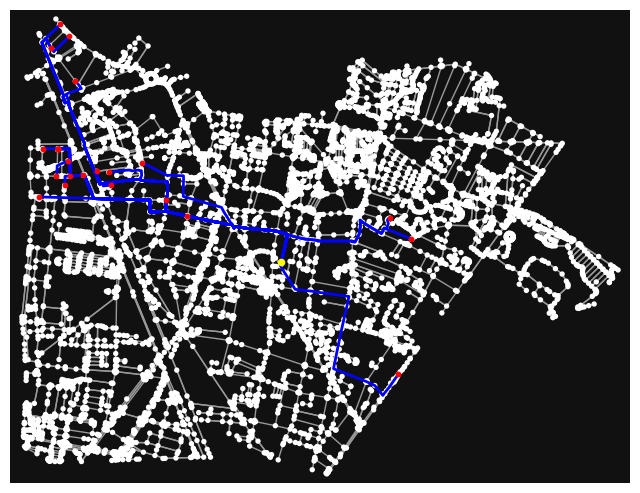

In [27]:
# On récupère les chemins construits grâce à Dijkstra entre tous les noeuds des bâtiments et la source
N = len(df)
shortest_path_edges = []
fig, ax = ox.plot_graph(G, show=False, close=False)
for i in range(N):
    path = nx.shortest_path(M, df['nodes'].iloc[i], source, weight='length_pond')
    path_xs = [gdf_nodes['x'].loc[node] for node in path]
    path_ys = [gdf_nodes['y'].loc[node] for node in path]
    ax.plot(path_xs, path_ys, color='blue', linewidth=2, zorder=4)
    shortest_path_edges.append(path)
# On affiche tous les bâtiments
for i in df['nodes']:
    ax.scatter (gdf_nodes['x'].loc[i], gdf_nodes['y'].loc[i], color='red', s = 10, zorder = 8)
ax.scatter (gdf_nodes['x'].loc[source], gdf_nodes['y'].loc[source], color='yellow', s = 20, zorder = 10)

In [20]:
# On crée un arbre qui représente le réseau : la source est la racine, et les enfants de chaque noeud correspondent aux noeux suivants dans le réseau (entre le noeud et les bâtiments finaux).
# Chaque apparaît au maximum une seule fois.
dic_arbre = {}
for l in shortest_path_edges:
    for i in range (len(l)-1, 0,-1):
        if l[i] in dic_arbre:
            if not (l[i-1] in dic_arbre[l[i]]):
                dic_arbre[l[i]].append(l[i-1])
        else:
            dic_arbre[l[i]] = [l[i-1]]

In [21]:
# On mémorise toutes les distances entre deux noeuds voisins qui sont dans l'arbre
def distance(noeud1, noeud2):
    id = tuple([noeud1,noeud2, 0])
    if id in gdf_edges.index: # On réalise ce test car l'arrête peut aussi bien s'appeler (noeud1, noeud2) que (noeud2, noeud1)
        return gdf_edges['length'].loc[id]
    else :
        id = tuple([noeud2,noeud1, 0])
        return gdf_edges['length'].loc[id]

In [22]:
# On simplifie l'arbre en supprimant tous les noeuds qui ne sont ni des intersections (un point ou le réseau se sépare en deux, il y a donc trois branches), ni la source, ni le noeud d'un bâtiment final
def simplifie ():
    dic_simp = {}
    dic_dist = {} # On va devoir mémoriser les distances
    def rec(noeud, parent, dist): # On utilise une fonction récursive pour parcourir tout l'arbre
        if noeud in df['nodes'].unique():# si c'est un noeud final
            dic_simp[parent] = dic_simp.get(parent, []) + [noeud]
            dic_dist[noeud] = dist
            l = dic_arbre.get(noeud, [])
            p = noeud
            for e in l:
                    dist = distance(noeud, e)
                    rec(e, p, dist)
        else: # si c'est une intersection (noeud final ou non)
            l = dic_arbre[noeud]
            if len(l) > 1:
                if noeud != parent:
                    dic_simp[parent] = dic_simp.get(parent, []) + [noeud]
                dic_dist[noeud] = dist
                p = noeud
                for e in l:
                    dist = distance(noeud, e)
                    rec(e, p, dist)
            else :
                p = parent
                suivant = l[0]
                dist += distance(noeud, suivant)
                rec(suivant, p, dist)
        return None
    rec(source, source, 0)
    return (dic_simp, dic_dist)
dic_arbre_simplifie, dic_dist = simplifie()

In [23]:
# On calcule le débit nécessaire dans chaque arête
dic_debit = {}
def debit (noeud):
    if noeud in df['nodes'].unique(): # si c'est un noeud final
        d = df[df['nodes'] == noeud]["debit"].sum()
        for i in dic_arbre_simplifie.get(noeud, []):
            d += debit(i) # on additionne tous les débits des arêtes "filles"
        dic_debit[noeud] = d
    else :
        d = 0
        for i in dic_arbre_simplifie[noeud]:
            d += debit(i)
        dic_debit[noeud] = d
    return d

debit(source)

4.710747414085943

In [24]:
# On crée des fonctions qui en fonction du débit, retourne le diamètre de la canalisation (en m) et
# la puissance dans la canalisation (en kW) associés

def diametre (debit):
  return (np.sqrt(debit/(np.pi*vitesse)))
def puissance (debit):
  return(debit*c_p*T*rho*10**(-3))

In [25]:
from math import *
# On réalise maintenant le tracé du réseau sur la carte, on utilise encore une fois une fonction récursive.

coords_source = [gdf_nodes['y'].loc[source], gdf_nodes['x'].loc[source]]
map = folium.Map(location=coords_source,zoom_start=15)
def trace (noeud):
    if noeud in df['nodes'].unique(): # si c'est le noeud à côté d'un bâtiment final
        coords = [gdf_nodes['y'].loc[noeud], gdf_nodes['x'].loc[noeud]]
        affichage = 'La puissance nécessaire est de ' + str(round(puissance(dic_debit[noeud]),1)) +'kW. \n Soit un débit de ' + str(round(dic_debit[noeud],2)) +'m3/s. \n Soit un diamètre de ' + str(round(diametre(dic_debit[noeud]), 3)) +'m \n La longueur du tuyau est de ' + str(round(dic_dist[noeud], 1)) +'m.'
        folium.Marker(coords, popup = affichage, icon=folium.Icon(color="purple")).add_to(map)
        folium.CircleMarker(location=coords, radius=2, weight=5, color = 'red').add_to(map)
        for suivant in dic_arbre.get(noeud, []):
            sui_coords = [gdf_nodes['y'].loc[suivant], gdf_nodes['x'].loc[suivant]]
            folium.PolyLine([coords, sui_coords], color = 'blue').add_to(map)
            trace(suivant)
    elif not (noeud in dic_arbre_simplifie): # si ce n'est pas une intersection ou pas un bâtiment final
        coords = [gdf_nodes['y'].loc[noeud], gdf_nodes['x'].loc[noeud]]
        suivant = dic_arbre[noeud][0]
        sui_coords = [gdf_nodes['y'].loc[suivant], gdf_nodes['x'].loc[suivant]]
        folium.PolyLine([coords, sui_coords], color = 'blue').add_to(map)
        trace(suivant)
    elif noeud == source: # si c'est la source
        affichage = 'La puissance nécessaire est de ' + str(round(puissance(dic_debit[noeud]),1)) +'kW. \n Soit un débit de ' + str(round(dic_debit[noeud],2)) +'m3/s. \n Soit un diamètre de ' + str(round(diametre(dic_debit[noeud]),3)) +'m.'
        folium.Marker(coords_source, popup = affichage, icon=folium.Icon(color="blue")).add_to(map)
        folium.CircleMarker(location=coords_source, radius=4, weight=5, color = 'green').add_to(map)
        for suivant in dic_arbre[noeud]:
            sui_coords = [gdf_nodes['y'].loc[suivant], gdf_nodes['x'].loc[suivant]]
            folium.PolyLine([coords_source, sui_coords], color = 'blue').add_to(map)
            trace(suivant)
    else : # si une intersection
        coords = [gdf_nodes['y'].loc[noeud], gdf_nodes['x'].loc[noeud]]
        affichage = 'La puissance nécessaire est de ' + str(round(puissance(dic_debit[noeud]),1)) +'kW. \n Soit un débit de ' + str(round(dic_debit[noeud],2)) +'m3/s. \n Soit un diamètre de ' + str(round(diametre(dic_debit[noeud]),3)) +'m \n La longueur du tuyau est de ' + str(round(dic_dist[noeud],1)) +'m.'
        folium.Marker(coords, popup = affichage, icon=folium.Icon(color="green")).add_to(map)
        folium.CircleMarker(location=coords, radius=2, weight=5, color = 'red').add_to(map)
        for suivant in dic_arbre[noeud]:
            sui_coords = [gdf_nodes['y'].loc[suivant], gdf_nodes['x'].loc[suivant]]
            folium.PolyLine([coords, sui_coords], color = 'blue').add_to(map)
            trace(suivant)
    return None
trace(source)
# Pour tous les noeuds d'un bâtiment final, on affiche aussi le bâtiment final ainsi que le trajet entre les deux.
for id in df.index:
    coords = [df.loc[id, 'lat'], df.loc[id, 'lon']]
    folium.CircleMarker(location=coords, radius=3, weight=5, color = 'yellow').add_to(map)
    node = df.loc[id, 'nodes']
    coords_node = [gdf_nodes['y'].loc[node], gdf_nodes['x'].loc[node]]
    folium.PolyLine([coords, coords_node], color = 'green').add_to(map)
map.save('carte_reseau_chaleur.html')